In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/Anxiety/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"
#data_file = DATA_PATH + "EPM_test_dict_May_17.pkl"
proj_file = PROJECT_PATH + "OFT_Holdout_Projections.csv"
#mean_file = PROJECT_PATH + "EPM_Holdout_mean_scores_w_agg.csv"

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"


old_feature_list = ["X_power_1_2","X_coh_1_2","X_gc_1_2"]
feature_weights = [10,1,1]



import os, sys
umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")


In [2]:
df_full = pd.read_csv(proj_file)
df_in_task = df_full[df_full['in-task']==1].copy()
df_in_hc = df_full[df_full['in-task']==0].copy()

Mouse04203
First Center Entry Latency in Seconds  70
Mouse39115
First Center Entry Latency in Seconds  40
Mouse39121
First Center Entry Latency in Seconds  36
Mouse39122
First Center Entry Latency in Seconds  10
Mouse39132
First Center Entry Latency in Seconds  6
Mouse39135
First Center Entry Latency in Seconds  16
Mouse69061
First Center Entry Latency in Seconds  29
Mouse69071
First Center Entry Latency in Seconds  21
Mouse69075
First Center Entry Latency in Seconds  6


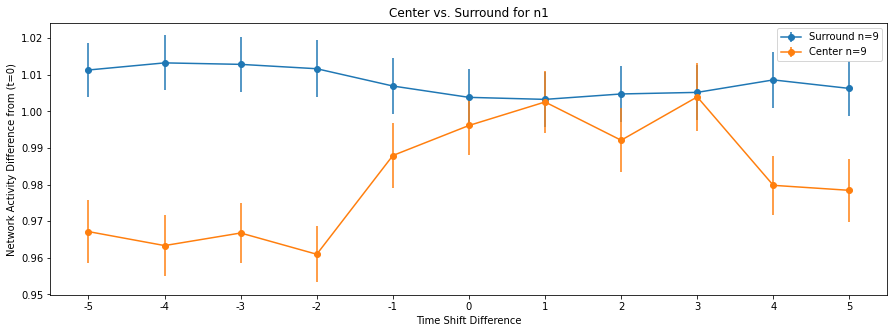

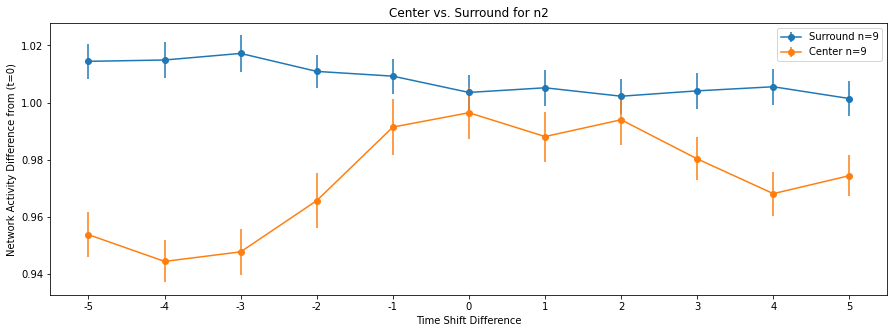

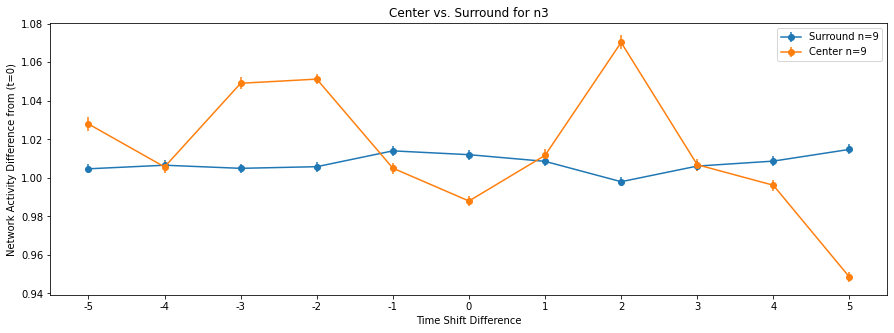

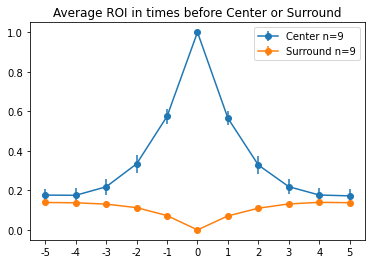

In [17]:
sliding_avg_size=5

allMice_ctr_means = []
allMice_surr_means = []
allMice_ctr_roi_means = []
allMice_surr_roi_means = []

allDiffs_ctr = []
allDiffs_surr = []
for mouse in np.unique(df_in_task.mouse):
    
    print(mouse)
    mouse_mask = df_in_task.mouse==mouse
    nan_filter = 1 - np.isnan(df_in_task.roi) 
    mask = np.logical_and(mouse_mask,nan_filter)
    
    in_center = df_in_task[mask==1].roi.values
    
    mouse_time = df_in_task[mask==1]["time"].values
    mouse_roi = df_in_task[mask==1]["roi"].values
    
    #nagg_s = df_in_task[mask==1]["agg score"].values
    n1_s = df_in_task[mask==1]["net 1 scores"].values
    n2_s = df_in_task[mask==1]["net 2 scores"].values
    n3_s = df_in_task[mask==1]["net 3 scores"].values
    
    mouse_ctr_avgs = []
    mouse_surr_avgs = []
    mouse_ctr_rois = []
    mouse_surr_rois = []
    mouse_avgs = []
    all_times = []
    ctr_centers = []
    surr_centers = []
    for idx, roi in enumerate(mouse_roi):
        
        if idx > sliding_avg_size and idx < (len(mouse_roi) - sliding_avg_size):
            
            #nagg_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n1_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n2_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n3_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            roi_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            center_time = mouse_time[idx]
            start_time = center_time - sliding_avg_size
            end_time = center_time + sliding_avg_size
            cont_time = np.arange(start_time,end_time+1)
            
            actual_time = mouse_time[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_roi = mouse_roi[idx-sliding_avg_size:idx+sliding_avg_size+1]
            
            #actual_nagg_scores = nagg_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n1_scores = n1_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n2_scores = n2_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n3_scores = n3_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            
            for i,time in enumerate(cont_time):
                if time in actual_time:
                    temp_mask = actual_time==time
                    #nagg_slice[i] = actual_nagg_scores[temp_mask==1][0]
                    n1_slice[i] = actual_n1_scores[temp_mask==1][0]
                    n2_slice[i] = actual_n2_scores[temp_mask==1][0]
                    n3_slice[i] = actual_n3_scores[temp_mask==1][0]
                    roi_slice[i] = actual_roi[temp_mask==1][0]
                    
            slice_means = [#nagg_slice,
                           n1_slice,
                           n2_slice,
                           n3_slice]
            
            all_times.append(center_time)
            mouse_avgs.append(np.array(slice_means))
            
            #if in the open arms
            if roi==1: 
                mouse_ctr_avgs.append(slice_means)
                mouse_ctr_rois.append(roi_slice)
                ctr_centers.append(center_time)
                
            elif roi==0:
                mouse_surr_avgs.append(slice_means)
                mouse_surr_rois.append(roi_slice)
                surr_centers.append(center_time)
                
                
            
    mouse_ctr_slice_mean = np.nanmean(mouse_ctr_avgs,axis=0)
    mouse_ctr_roi_mean = np.nanmean(mouse_ctr_rois,axis=0)
    
    mouse_surr_slice_mean = np.nanmean(mouse_surr_avgs,axis=0)
    mouse_surr_roi_mean = np.nanmean(mouse_surr_rois,axis=0)
    
    allMice_ctr_means.append(mouse_ctr_slice_mean)
    allMice_surr_means.append(mouse_surr_slice_mean)
    
    allMice_ctr_roi_means.append(mouse_ctr_roi_mean)
    allMice_surr_roi_means.append(mouse_surr_roi_mean)
    print("First Center Entry Latency in Seconds ",np.min(ctr_centers) - np.min(mouse_time))

allMice_ctr_means = np.array(allMice_ctr_means)
allMice_surr_means = np.array(allMice_surr_means)
allMice_ctr_roi_means = np.array(allMice_ctr_roi_means)
allMice_surr_roi_means = np.array(allMice_surr_roi_means)
for i, net in zip(range(4),["n1","n2","n3"]):

    plt.figure(figsize=(15,5))
    shared_meanish = np.mean(allMice_ctr_means,axis=0)[i][5] / 2 + np.mean(allMice_surr_means,axis=0)[i][5] / 2
    #plt.subplot(1,2,1)
    ctr_mean = np.mean(allMice_ctr_means / shared_meanish,axis=0)
    ctr_stderr = np.std(allMice_ctr_means,axis=0) / np.sqrt(len(allMice_ctr_means))
    
    surr_mean = np.mean(allMice_surr_means / shared_meanish ,axis=0)
    surr_stderr = np.std(allMice_surr_means,axis=0) / np.sqrt(len(allMice_surr_means))

    
    plt.errorbar(np.arange(11),surr_mean[i,:],yerr=surr_stderr[i,:],fmt="-o", label="Surround n={}".format(len(allMice_surr_means)))
    plt.xticks(np.arange(11), np.arange(11)-5)
    
    plt.errorbar(np.arange(11),ctr_mean[i,:],yerr=ctr_stderr[i,:],fmt="-o", label="Center n={}".format(len(allMice_ctr_means)))
    plt.xticks(np.arange(11), np.arange(11)-5)


    #plt.title("Center for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    #plt.subplot(1,2,2)

    plt.title("Center vs. Surround for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    plt.legend()
    plt.show()
    
ctr_roi_mean = np.mean(allMice_ctr_roi_means,axis=0)
ctr_roi_sterr = np.std(allMice_ctr_roi_means,axis=0) / np.sqrt(len(allMice_ctr_roi_means))
plt.errorbar(np.arange(11),ctr_roi_mean,yerr=ctr_roi_sterr,fmt="-o", label="Center n={}".format(len(allMice_ctr_means)))

surr_roi_mean = np.mean(allMice_surr_roi_means,axis=0)
surr_roi_sterr = np.std(allMice_surr_roi_means,axis=0) / np.sqrt(len(allMice_surr_roi_means))
plt.errorbar(np.arange(11),surr_roi_mean,yerr=surr_roi_sterr,fmt="-o", label="Surround n={}".format(len(allMice_surr_means)))

plt.legend()
plt.xticks(np.arange(11), np.arange(11)-5)
plt.title("Average ROI in times before Center or Surround")
plt.show()
                                                    

In [25]:
allMice_surr_roi_means.shape

mouse_ids = np.hstack([np.unique(df_in_task.mouse),np.unique(df_in_task.mouse)]).reshape(-1,1)
center_location = np.hstack([["ctr" for _ in np.unique(df_in_task.mouse)],
                             ["surr" for _ in np.unique(df_in_task.mouse)]]).reshape(-1,1)
save_rois = np.vstack([allMice_ctr_roi_means, allMice_surr_roi_means])

df_roi_save = pd.DataFrame(np.hstack([mouse_ids,center_location,save_rois]),
                           columns = ["mouse","location"] + list(np.arange(-5,6).astype(str)))
df_roi_save.to_csv(PROJECT_PATH + "BOF_Center_vs_Surround_11_second_neighborhood_rois.csv",index=False)

In [23]:
save_rois.shape

(18, 11)

In [57]:
for mouse in np.unique(df_in_task.mouse):
    mouse_mask=df_in_task.mouse==mouse
    print("mouse: {} ratio: {}".format(mouse,(np.sum(df_in_task[mouse_mask==1].roi)/ np.sum(mouse_mask))))
    print("task time", np.sum(mouse_mask))

mouse: Mouse04203 ratio: 0.09116022099447514
task time 362
mouse: Mouse39115 ratio: 0.16257668711656442
task time 326
mouse: Mouse39121 ratio: 0.10461538461538461
task time 325
mouse: Mouse39122 ratio: 0.15816326530612246
task time 392
mouse: Mouse39132 ratio: 0.17220543806646527
task time 331
mouse: Mouse39135 ratio: 0.16483516483516483
task time 273
mouse: Mouse69061 ratio: 0.18980169971671387
task time 353
mouse: Mouse69071 ratio: 0.125
task time 344
mouse: Mouse69075 ratio: 0.159375
task time 320


In [56]:
np.sum(mouse_mask)

320

In [47]:
ctr_mouse_segments = []
surr_mouse_segments = []

for i, net in zip(range(4),["n1","n2","n3"]):
    chunk_ctr = np.hstack([np.unique(df_in_task.mouse).reshape(-1,1).astype(object),
                         np.array([net for _ in range(9)]).reshape(-1,1).astype(object),
                         np.array(["Center" for _ in range(9)]).reshape(-1,1).astype(object),
                         np.array(allMice_ctr_means)[:,i,:]]).astype(object)
    
    chunk_surr = np.hstack([np.unique(df_in_task.mouse).reshape(-1,1).astype(object),
                         np.array([net for _ in range(9)]).reshape(-1,1).astype(object),
                         np.array(["Surround" for _ in range(9)]).reshape(-1,1).astype(object),
                         np.array(allMice_surr_means)[:,i,:]]).astype(object)
    
    ctr_mouse_segments.append(chunk_ctr)
    surr_mouse_segments.append(chunk_surr)
    

saveData = np.vstack([
                    np.vstack(ctr_mouse_segments),
                    np.vstack(surr_mouse_segments)
                    ])

df_save = pd.DataFrame(saveData,columns = ["mouse","network","location"] + list(np.arange(-5,6).astype(str)))
df_save.to_csv(PROJECT_PATH + "BOF_Center_vs_Surround_11_second_neighborhood_all_nets.csv",index=False)


Mouse04203
First Center Entry Latency in Seconds  70
First Saved Surround Timepoint  6
Last Center Entry Latency in Seconds  279
Last Saved Surround Timepoint  294
Mouse39115
First Center Entry Latency in Seconds  40
First Saved Surround Timepoint  6
Last Center Entry Latency in Seconds  259
Last Saved Surround Timepoint  293
Mouse39121
First Center Entry Latency in Seconds  36
First Saved Surround Timepoint  7
Last Center Entry Latency in Seconds  286
Last Saved Surround Timepoint  294
Mouse39122
First Center Entry Latency in Seconds  10
First Saved Surround Timepoint  6
Last Center Entry Latency in Seconds  289
Last Saved Surround Timepoint  294
Mouse39132
First Center Entry Latency in Seconds  6
First Saved Surround Timepoint  11
Last Center Entry Latency in Seconds  280
Last Saved Surround Timepoint  294
Mouse39135
First Center Entry Latency in Seconds  16
First Saved Surround Timepoint  12
Last Center Entry Latency in Seconds  292
Last Saved Surround Timepoint  288
Mouse69061
Firs

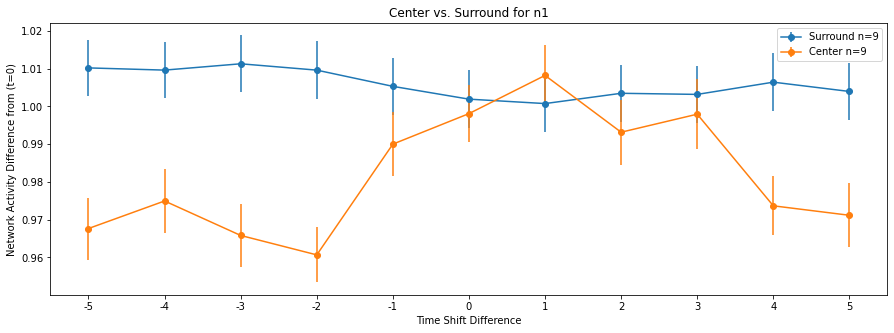

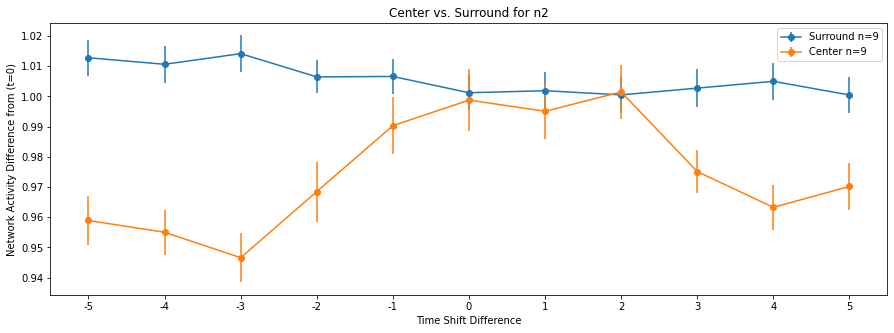

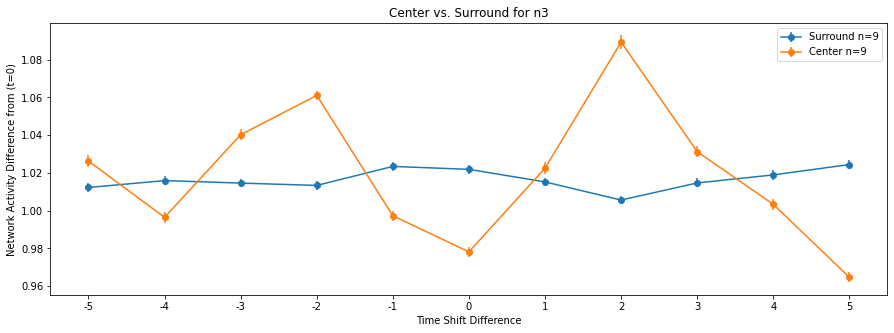

In [3]:
sliding_avg_size=5

allMice_ctr_means = []
allMice_surr_means = []

allDiffs_ctr = []
allDiffs_surr = []

ctr_time_means = []
surr_time_means = []
for mouse in np.unique(df_in_task.mouse):
    
    print(mouse)
    mouse_mask = df_in_task.mouse==mouse
    nan_filter = 1 - np.isnan(df_in_task.roi) 
    mask = np.logical_and(mouse_mask,nan_filter)
    time_mask = df_in_task["time"] < np.min(df_in_task[mask==1].time) + 300
    mask = np.logical_and(mask,time_mask)
    
    in_center = df_in_task[mask==1].roi.values
    
    mouse_time = df_in_task[mask==1]["time"].values
    mouse_roi = df_in_task[mask==1]["roi"].values
    
    #nagg_s = df_in_task[mask==1]["agg score"].values
    n1_s = df_in_task[mask==1]["net 1 scores"].values
    n2_s = df_in_task[mask==1]["net 2 scores"].values
    n3_s = df_in_task[mask==1]["net 3 scores"].values
    
    mouse_ctr_avgs = []
    mouse_surr_avgs = []
    mouse_avgs = []
    all_times = []
    ctr_centers = []
    surr_centers = []
    postFirstEntry=False
    
    for idx, roi in enumerate(mouse_roi):
        
        if idx > sliding_avg_size and idx < (len(mouse_roi) - sliding_avg_size):
            
            #nagg_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n1_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n2_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n3_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            
            center_time = mouse_time[idx]
            start_time = center_time - sliding_avg_size
            end_time = center_time + sliding_avg_size
            cont_time = np.arange(start_time,end_time+1)
            
            actual_time = mouse_time[idx-sliding_avg_size:idx+sliding_avg_size+1]
            
            #actual_nagg_scores = nagg_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n1_scores = n1_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n2_scores = n2_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n3_scores = n3_s[idx-sliding_avg_size:idx+sliding_avg_size+1]

            for i,time in enumerate(cont_time):
                if time in actual_time:
                    temp_mask = actual_time==time
                    #nagg_slice[i] = actual_nagg_scores[temp_mask==1][0]
                    n1_slice[i] = actual_n1_scores[temp_mask==1][0]
                    n2_slice[i] = actual_n2_scores[temp_mask==1][0]
                    n3_slice[i] = actual_n3_scores[temp_mask==1][0]
                    
            slice_means = [#nagg_slice,
                           n1_slice,
                           n2_slice,
                           n3_slice]
            
            all_times.append(center_time)
            mouse_avgs.append(np.array(slice_means))
            #if in the open arms
            if roi==1: 
                postFirstEntry=True
                mouse_ctr_avgs.append(slice_means)
                ctr_centers.append(center_time)
                
            elif roi==0: #and postFirstEntry:
                mouse_surr_avgs.append(slice_means)
                surr_centers.append(center_time)
                
            
    ctr_time_means.append(np.mean(ctr_centers) - np.min(mouse_time))
    surr_time_means.append(np.mean(surr_centers) - np.min(mouse_time))
    
    mouse_ctr_slice_mean = np.nanmean(mouse_ctr_avgs,axis=0)
    mouse_surr_slice_mean = np.nanmean(mouse_surr_avgs,axis=0)
    
    allMice_ctr_means.append(mouse_ctr_slice_mean)
    allMice_surr_means.append(mouse_surr_slice_mean)
    
    print("First Center Entry Latency in Seconds ",np.min(ctr_centers) - np.min(mouse_time))
    print("First Saved Surround Timepoint ",np.min(surr_centers) - np.min(mouse_time))
    
    print("Last Center Entry Latency in Seconds ",np.max(ctr_centers) - np.min(mouse_time))
    print("Last Saved Surround Timepoint ",np.max(surr_centers) - np.min(mouse_time))

allMice_ctr_means = np.array(allMice_ctr_means)
allMice_surr_means = np.array(allMice_surr_means)

for i, net in zip(range(4),["n1","n2","n3"]):

    plt.figure(figsize=(15,5))
    shared_meanish = np.mean(allMice_ctr_means,axis=0)[i][5] / 2 + np.mean(allMice_surr_means,axis=0)[i][5] / 2
    #plt.subplot(1,2,1)
    ctr_mean = np.mean(allMice_ctr_means / shared_meanish,axis=0)
    ctr_stderr = np.std(allMice_ctr_means,axis=0) / np.sqrt(len(allMice_ctr_means))
    
    surr_mean = np.mean(allMice_surr_means / shared_meanish ,axis=0)
    surr_stderr = np.std(allMice_surr_means,axis=0) / np.sqrt(len(allMice_surr_means))

    
    plt.errorbar(np.arange(11),surr_mean[i,:],yerr=surr_stderr[i,:],fmt="-o", label="Surround n={}".format(len(allMice_surr_means)))
    plt.xticks(np.arange(11), np.arange(11)-5)
    
    plt.errorbar(np.arange(11),ctr_mean[i,:],yerr=ctr_stderr[i,:],fmt="-o", label="Center n={}".format(len(allMice_ctr_means)))
    plt.xticks(np.arange(11), np.arange(11)-5)


    #plt.title("Center for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    #plt.subplot(1,2,2)

    plt.title("Center vs. Surround for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    plt.legend()
    plt.show()

In [17]:
np.max(surr_centers)

703

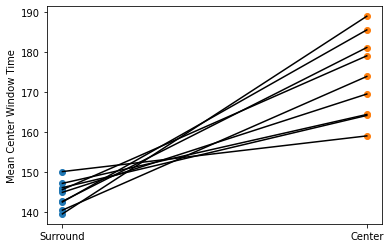

In [4]:
plt.scatter(np.zeros(9),surr_time_means)
plt.scatter(np.ones(9),ctr_time_means)

for i in range(9):
    plt.plot([0,1],[surr_time_means[i],ctr_time_means[i]],color="black")
    

plt.xticks([0,1],["Surround","Center"])
plt.ylabel("Mean Center Window Time")
plt.show()

df_surr_center_times = pd.DataFrame.from_dict({
    "mouse":np.unique(df_in_task.mouse).squeeze(),
    "surr_mean_time":surr_time_means,
    "ctr_means_time":ctr_time_means,
})

#df_surr_center_times.to_csv(PROJECT_PATH + "BOF_Cen_vs_Surr_mean_times.csv",index=False)

In [5]:
df_surr_center_times

,mouse,surr_mean_time,ctr_means_time
0,Mouse04203,150.206226,159.103448
1,Mouse39115,142.611814,185.536585
2,Mouse39121,145.698413,179.071429
3,Mouse39122,145.024490,169.545455
4,Mouse39132,146.197425,164.204082
5,Mouse39135,140.583756,173.930233
6,Mouse69061,142.775330,181.148148
7,Mouse69071,139.643777,188.947368
8,Mouse69075,147.265560,164.446809


In [25]:
for mouse in np.unique(df_in_task.mouse):
    mouse_mask= df_in_task.mouse==mouse
    startTime = np.min(df_in_task[mouse_mask==1].time)
    endTime = startTime + 300
    time_mask = np.logical_and(df_in_task.time >= startTime,
                               df_in_task.time < endTime)
    mask = np.logical_and(mouse_mask,time_mask)
    rois = df_in_task.roi
    
    n_nans = np.sum(np.isnan(rois[mask==1]))
    
    center_mask = np.logical_and(mask,rois)
    surr_mask = np.logical_and(mask,rois==0)
    
    perc_center = np.sum(center_mask) / np.sum(mask)#(300 - np.sum(np.isnan(rois[mask==1])))
    mean_center = np.mean(df_in_task[center_mask==1].time).astype(int) - startTime
                               
    perc_surr = np.sum(surr_mask) / np.sum(mask)#(300 - np.sum(np.isnan(rois[mask==1])))
    mean_surr = np.mean(df_in_task[surr_mask==1].time).astype(int) - startTime
    
    print_string = "{} surr perc/time: {:.3f} {} center perc/time: {:.3f} {}"
    print(np.sum(mask))
    print(print_string.format(mouse,perc_surr,mean_surr,
                              perc_center,mean_center))
    
    

297
Mouse04203 surr perc/time: 0.899 150 center perc/time: 0.101 154
289
Mouse39115 surr perc/time: 0.855 141 center perc/time: 0.145 188
291
Mouse39121 surr perc/time: 0.900 145 center perc/time: 0.100 172
289
Mouse39122 surr perc/time: 0.879 145 center perc/time: 0.121 160
293
Mouse39132 surr perc/time: 0.823 147 center perc/time: 0.177 154
251
Mouse39135 surr perc/time: 0.821 141 center perc/time: 0.179 166
292
Mouse69061 surr perc/time: 0.808 142 center perc/time: 0.192 180
282
Mouse69071 surr perc/time: 0.862 139 center perc/time: 0.138 185
299
Mouse69075 surr perc/time: 0.836 147 center perc/time: 0.164 157


In [23]:
np.sum(time_mask)

2333

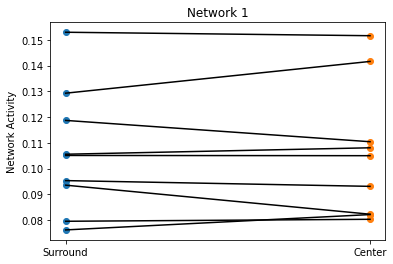

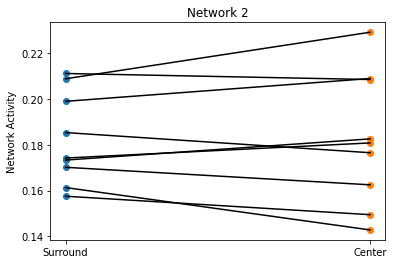

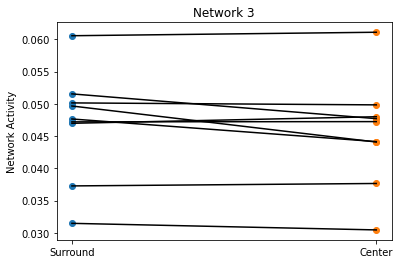

In [15]:
for net in range(3):
    plt.scatter(np.zeros(9),allMice_surr_means[:,net,:][:,5])
    plt.scatter(np.ones(9),allMice_ctr_means[:,net,:][:,5])
    mouse_lines = np.hstack([allMice_surr_means[:,net,:][:,5].reshape(-1,1),allMice_ctr_means[:,net,:][:,5].reshape(-1,1)])
    mouse_x = np.hstack([np.zeros(9).reshape(-1,1),np.ones(9).reshape(-1,1)])
    
    for i in range(9):
        plt.plot(mouse_x[i],mouse_lines[i],color="black")
        
    
    plt.xticks([0,1],["Surround","Center"])
    plt.ylabel("Network Activity")
    plt.title("Network {}".format(net+1))
    plt.show()
    

In [25]:
temp_mask

array([False, False, False, False, False,  True, False, False, False,
       False, False])

## Limit to Second half recording of Surround

Mouse04203
First Center Entry Latency in Seconds  70
First Saved Surround Timepoint  152
Mouse39115
First Center Entry Latency in Seconds  40
First Saved Surround Timepoint  157
Mouse39121
First Center Entry Latency in Seconds  36
First Saved Surround Timepoint  151
Mouse39122
First Center Entry Latency in Seconds  10
First Saved Surround Timepoint  151
Mouse39132
First Center Entry Latency in Seconds  6
First Saved Surround Timepoint  151
Mouse39135
First Center Entry Latency in Seconds  16
First Saved Surround Timepoint  151
Mouse69061
First Center Entry Latency in Seconds  29
First Saved Surround Timepoint  151
Mouse69071
First Center Entry Latency in Seconds  21
First Saved Surround Timepoint  151
Mouse69075
First Center Entry Latency in Seconds  6
First Saved Surround Timepoint  151


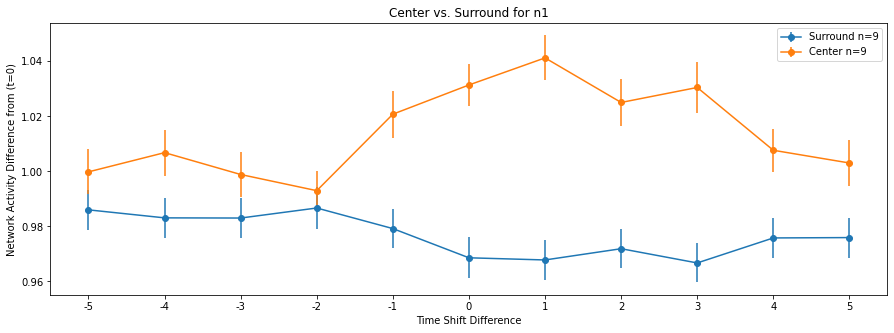

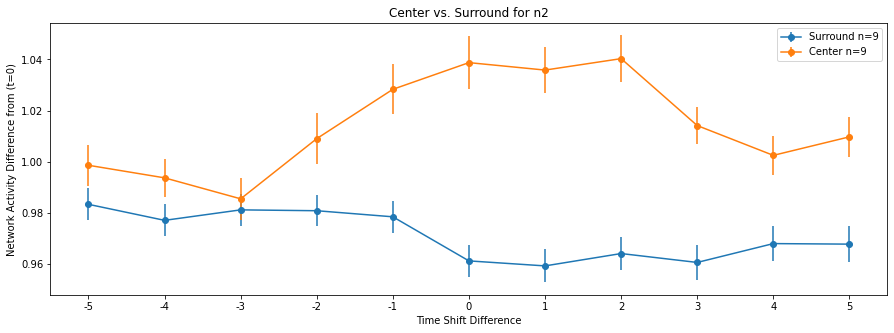

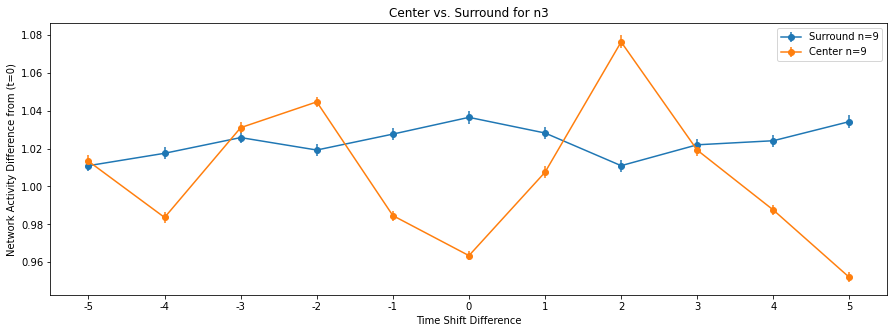

In [20]:
sliding_avg_size=5

allMice_ctr_means = []
allMice_surr_means = []

allDiffs_ctr = []
allDiffs_surr = []

ctr_time_means = []
surr_time_means = []
for mouse in np.unique(df_in_task.mouse):
    
    print(mouse)
    mouse_mask = df_in_task.mouse==mouse
    nan_filter = 1 - np.isnan(df_in_task.roi) 
    mask = np.logical_and(mouse_mask,nan_filter)
    
    in_center = df_in_task[mask==1].roi.values
    
    mouse_time = df_in_task[mask==1]["time"].values
    mouse_roi = df_in_task[mask==1]["roi"].values
    
    #nagg_s = df_in_task[mask==1]["agg score"].values
    n1_s = df_in_task[mask==1]["net 1 scores"].values
    n2_s = df_in_task[mask==1]["net 2 scores"].values
    n3_s = df_in_task[mask==1]["net 3 scores"].values
    
    mouse_ctr_avgs = []
    mouse_surr_avgs = []
    mouse_avgs = []
    all_times = []
    ctr_centers = []
    surr_centers = []
    postFirstEntry=False
    
    for idx, roi in enumerate(mouse_roi):
        
        if idx > sliding_avg_size and idx < (len(mouse_roi) - sliding_avg_size):
            
            #nagg_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n1_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n2_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n3_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            
            center_time = mouse_time[idx]
            start_time = center_time - sliding_avg_size
            end_time = center_time + sliding_avg_size
            cont_time = np.arange(start_time,end_time+1)
            
            actual_time = mouse_time[idx-sliding_avg_size:idx+sliding_avg_size+1]
            
            #actual_nagg_scores = nagg_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n1_scores = n1_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n2_scores = n2_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n3_scores = n3_s[idx-sliding_avg_size:idx+sliding_avg_size+1]

            for i,time in enumerate(cont_time):
                if time in actual_time:
                    temp_mask = actual_time==time
                    #nagg_slice[i] = actual_nagg_scores[temp_mask==1][0]
                    n1_slice[i] = actual_n1_scores[temp_mask==1][0]
                    n2_slice[i] = actual_n2_scores[temp_mask==1][0]
                    n3_slice[i] = actual_n3_scores[temp_mask==1][0]
                    
            slice_means = [#nagg_slice,
                           n1_slice,
                           n2_slice,
                           n3_slice]
            
            all_times.append(center_time)
            mouse_avgs.append(np.array(slice_means))
            #if in the open arms
            if roi==1 and (center_time - np.min(mouse_time))<300: 
                postFirstEntry=True
                mouse_ctr_avgs.append(slice_means)
                ctr_centers.append(center_time)
                
            elif roi==0 and (center_time - np.min(mouse_time))>150 and (center_time - np.min(mouse_time))<300:
                mouse_surr_avgs.append(slice_means)
                surr_centers.append(center_time)
                
            
    ctr_time_means.append(np.mean(ctr_centers) - np.min(mouse_time))
    surr_time_means.append(np.mean(surr_centers) - np.min(mouse_time))
    
    mouse_ctr_slice_mean = np.nanmean(mouse_ctr_avgs,axis=0)
    mouse_surr_slice_mean = np.nanmean(mouse_surr_avgs,axis=0)
    
    allMice_ctr_means.append(mouse_ctr_slice_mean)
    allMice_surr_means.append(mouse_surr_slice_mean)
    
    print("First Center Entry Latency in Seconds ",np.min(ctr_centers) - np.min(mouse_time))
    print("First Saved Surround Timepoint ",np.min(surr_centers) - np.min(mouse_time))

allMice_ctr_means = np.array(allMice_ctr_means)
allMice_surr_means = np.array(allMice_surr_means)

for i, net in zip(range(4),["n1","n2","n3"]):

    plt.figure(figsize=(15,5))
    shared_meanish = np.mean(allMice_ctr_means,axis=0)[i][5] / 2 + np.mean(allMice_surr_means,axis=0)[i][5] / 2
    #plt.subplot(1,2,1)
    ctr_mean = np.mean(allMice_ctr_means / shared_meanish,axis=0)
    ctr_stderr = np.std(allMice_ctr_means,axis=0) / np.sqrt(len(allMice_ctr_means))
    
    surr_mean = np.mean(allMice_surr_means / shared_meanish ,axis=0)
    surr_stderr = np.std(allMice_surr_means,axis=0) / np.sqrt(len(allMice_surr_means))

    
    plt.errorbar(np.arange(11),surr_mean[i,:],yerr=surr_stderr[i,:],fmt="-o", label="Surround n={}".format(len(allMice_surr_means)))
    plt.xticks(np.arange(11), np.arange(11)-5)
    
    plt.errorbar(np.arange(11),ctr_mean[i,:],yerr=ctr_stderr[i,:],fmt="-o", label="Center n={}".format(len(allMice_ctr_means)))
    plt.xticks(np.arange(11), np.arange(11)-5)


    #plt.title("Center for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    #plt.subplot(1,2,2)

    plt.title("Center vs. Surround for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    plt.legend()
    plt.show()

## Plot Surround activity over time across mice

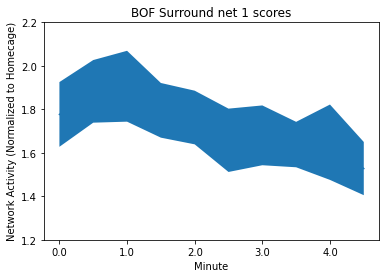

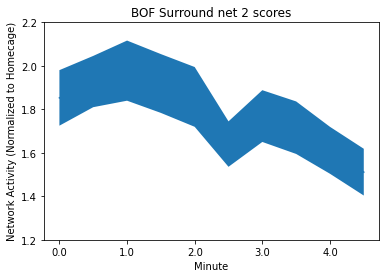

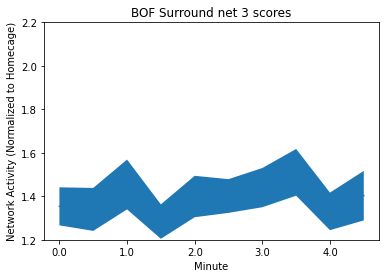

In [3]:
max_size = 300

network_score_matrices = []
for net_type in ["net 1 scores","net 2 scores", "net 3 scores"]:
    score_matrix = np.zeros((np.unique(df_in_task.mouse).shape[0],max_size)) * np.nan
    mouse_hc_mean_scores = []
    for idx,mouse in enumerate(np.unique(df_in_task.mouse)):
        mouse_mask = df_in_task.mouse==mouse
        mouse_start_time = np.min(df_in_task[mouse_mask==1].time)
        mouse_max_time = mouse_start_time + max_size
        time_mask = np.logical_and(df_in_task.time >= mouse_start_time, df_in_task.time < mouse_max_time)
        mask= np.logical_and(mouse_mask,time_mask)
        
        nan_mask = 1 - df_in_task[mask==1]["roi"].values
        nan_mask[nan_mask==0]=np.nan
        
        
        scores = df_in_task[mask==1][net_type]*nan_mask / np.nanmean(df_in_hc[df_in_hc.mouse==mouse][net_type])
        times = df_in_task[mask==1].time - df_in_task[mask==1].time.values[0]
        mouse_hc_mean_scores.append(np.nanmean(df_in_hc[df_in_hc.mouse==mouse][net_type].values))
        keep_scores = []
        for time in range(max_size):
            if time in list(times):
                score_idx = np.where(times==time)[0][0]
                keep_scores.append(scores.values[score_idx])
            else:
                keep_scores.append(np.nan)
                
        keep_scores = np.array(keep_scores)
        
        #keep_scores = [scores[np.where(times==time)[0][0]] if time in times else np.nan for time in range(300)]
        
        score_matrix[idx,:] = keep_scores
        
    saveMat = np.hstack([np.unique(df_in_task.mouse).reshape(-1,1),
                         np.array(mouse_hc_mean_scores).reshape(-1,1),
                         score_matrix]).astype(object)
    df_temp = pd.DataFrame(saveMat,
                           columns = ["mouse","HC_mean_scores"] + list(np.arange(1,301).astype(str)))
    network_score_matrices.append(df_temp)
    #df_temp.to_csv(PROJECT_PATH + "_".join(net_type.split(" ")) + "_BOF_surround_scores_over_time_w_HC_mean.csv")
    second_averages = 30
    mean = np.nanmean(np.nanmean(score_matrix.reshape(9,-1,second_averages),axis=2),axis=0)
    sterr = np.nanstd(np.nanmean(score_matrix.reshape(9,-1,second_averages),axis=2),axis=0) / np.sqrt(9)
    plt.plot(mean)
    plt.fill_between(range(int(max_size/second_averages)),mean + sterr, mean - sterr)
    
    #plt.xticks(np.arange(int(max_size/second_averages)), np.arange(0,max_size,int(max_size/second_averages)))
    plt.title("BOF Surround "+net_type)
    plt.ylabel("Network Activity")
    plt.xlabel("Network Activity")
    plt.xticks(np.arange(0,10,2),np.arange(0,10,2)*30/60)
    plt.xlabel("Minute")
    plt.ylabel("Network Activity (Normalized to Homecage)")
    plt.ylim([1.2,2.2])
    plt.show()

In [4]:
1 - np.isnan(score_matrix[-1,:])

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
1 - df_in_task[mask==1]["roi"].values.astype(int)

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
import pingouin as pg
from scipy.stats import boxcox

def sample_Neighborhood_Impute(s,size=5):
    s = s.squeeze()
    missing_mask = np.isnan(s.squeeze())
    #print(np.sum(missing_mask))
    #print(missing_mask)
    idxs = np.where(np.isnan(s.squeeze()))[0]
    #print(idxs)
    #print(np.where(np.isnan(s)))
    for idx in idxs:
        if idx - size < 0:
            s[idx] = np.nanmean(s[:idx+size])
        elif idx + size > len(s):
            s[idx] = np.nanmean(s[idx-size:])
        else:
            s[idx] = np.nanmean(s[idx-size:idx+size])
            
    return s

def reshape_df(df):
    mouse_id_list = []
    scores_list = []
    time_list = []
    for m_id, mouse in enumerate(df.mouse):
        print(mouse)
        mouse_id_list.append([m_id for _ in range(len(df.columns) - 1)])
        
        
        scores_list.append(df[df.mouse==mouse][np.arange(len(df.columns)-1).astype(str)].values.astype(float))
        temp_scores = scores_list[-1]
        #print(temp_scores)
        temp_scores = sample_Neighborhood_Impute(temp_scores)
        #print(temp_scores)
        scores_list[-1] = temp_scores
        time_list.append(np.arange(len(df.columns)-1))
        
        
    mouse_id_list = np.array(mouse_id_list).reshape(-1,1) + 1
    scores_list = np.array(scores_list).reshape(-1,1)
    time_list = np.array(time_list).reshape(-1,1) + 1
      
    df_new = pd.DataFrame.from_dict({"mouse":mouse_id_list.squeeze(),
                                     "scores":scores_list.squeeze().astype(float),
                           "bxcx_scores":boxcox(20*scores_list.squeeze().astype(float))[0],
                           "time":time_list.squeeze().astype(float)})
    
    return df_new

n1_df = reshape_df(network_score_matrices[0])
n2_df = reshape_df(network_score_matrices[1])
        

Mouse04203


KeyError: "['0'] not in index"

### Bright Open Field 1 way anova time effect surround - Network 1

In [7]:
pg.rm_anova(dv="bxcx_scores",within="time",subject="mouse",data=n1_df)

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,time,299,2392,1.482176,8.175624e-07,0.089488,0.024087


### Bright Open Field 1 way anova time effect surround - Network 2

In [8]:
pg.rm_anova(dv="bxcx_scores",within="time",subject="mouse",data=n2_df)

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,time,299,2392,1.61183,2.136023e-09,0.12121,0.024687


# Drop first 120s of Time

Mouse04203
Mouse39115
Mouse39121
Mouse39122
Mouse39132
Mouse39135
Mouse69061
Mouse69071
Mouse69075


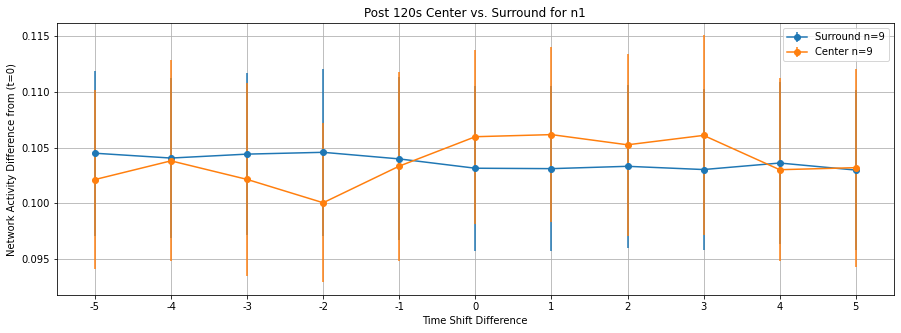

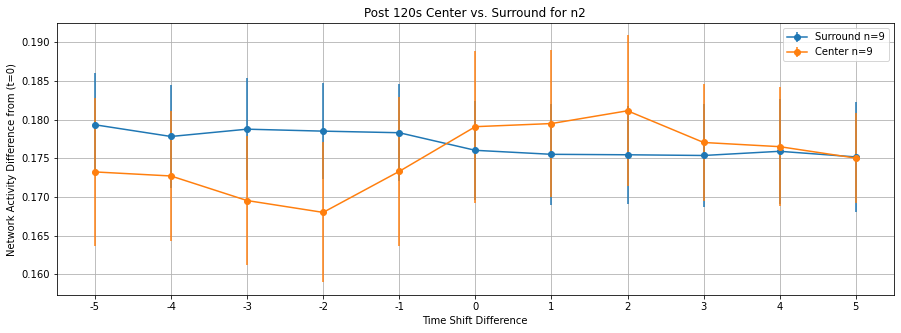

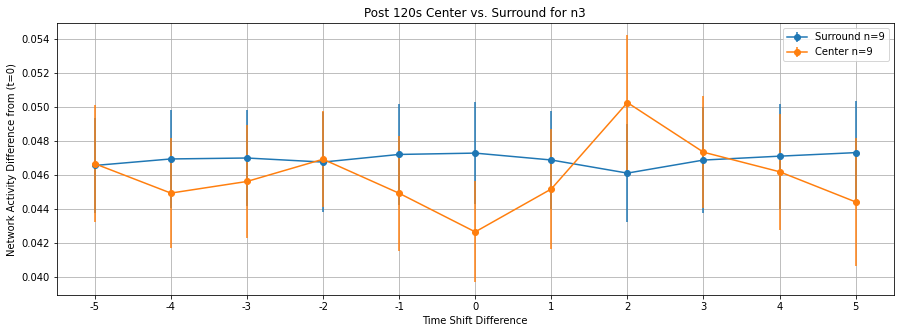

,mouse,location,network,mean_surr_score,-5,-4,-3,-2,-1,0,1,2,3,4,5
0,Mouse04203,ctr,1,0.105036,0.101038,0.114528,0.112998,0.104826,0.106075,0.111281,0.11232,0.111792,0.11423,0.106597,0.102756
1,Mouse39115,ctr,1,0.090502,0.076393,0.078032,0.07896,0.075811,0.07929,0.07999,0.079603,0.084307,0.085907,0.08544,0.087645
2,Mouse39121,ctr,1,0.145805,0.148541,0.154865,0.150702,0.135667,0.149713,0.146818,0.148792,0.152732,0.153878,0.146694,0.155685
3,Mouse39122,ctr,1,0.074713,0.07989,0.074198,0.071218,0.078831,0.078783,0.089804,0.088905,0.0798,0.070743,0.072411,0.070573
4,Mouse39132,ctr,1,0.126811,0.133054,0.137558,0.13686,0.132438,0.140564,0.140507,0.139723,0.1389,0.143641,0.136834,0.137061
5,Mouse39135,ctr,1,0.077387,0.075076,0.073621,0.076061,0.078039,0.074783,0.075696,0.077877,0.081668,0.080091,0.075535,0.072113
6,Mouse69061,ctr,1,0.088837,0.091956,0.089173,0.088261,0.087678,0.087434,0.0921,0.093223,0.087342,0.088479,0.086952,0.088821
7,Mouse69071,ctr,1,0.117925,0.113212,0.112039,0.106631,0.111081,0.110189,0.110393,0.111142,0.106972,0.116824,0.113845,0.107952
8,Mouse69075,ctr,1,0.100922,0.09992,0.100198,0.097521,0.095966,0.103108,0.107142,0.103837,0.103675,0.101001,0.102737,0.106095
9,Mouse04203,surr,1,0.105036,0.107133,0.1051,0.105082,0.106334,0.105691,0.105036,0.105053,0.105176,0.105089,0.105877,0.105533


In [150]:
offset = 120

sliding_avg_size=5

allMice_ctr_means = []
allMice_surr_means = []

allDiffs_ctr = []
allDiffs_surr = []

ctr_time_means = []
surr_time_means = []

mouse_n1_mean_surr_score = []
mouse_n2_mean_surr_score = []
mouse_n3_mean_surr_score = []

for mouse in np.unique(df_in_task.mouse):
    
    print(mouse)
    mouse_mask = df_in_task.mouse==mouse
    nan_filter = 1 - np.isnan(df_in_task.roi) 
    mask = np.logical_and(mouse_mask,nan_filter)
    startTime = np.min(df_in_task[mask==1]["time"])
    
    time_mask = np.logical_and(df_in_task["time"] < startTime + 300,
                               df_in_task["time"] >= startTime+offset)
    
    mask = np.logical_and(mask,time_mask)
    
    in_center = df_in_task[mask==1].roi.values
    
    mouse_time = df_in_task[mask==1]["time"].values
    mouse_roi = df_in_task[mask==1]["roi"].values
    
    surround_mask = np.logical_and(mask,
                                   df_in_task["roi"]==0)
    
    surround_time = np.logical_and(df_in_task["time"] < startTime + 300 - 5,
                               df_in_task["time"] >= startTime+offset + 5)
    
    surround_mask = np.logical_and(surround_mask,surround_time)
    
    #nagg_s = df_in_task[mask==1]["agg score"].values
    n1_s = df_in_task[mask==1]["net 1 scores"].values #/ np.mean(df_in_task[surround_mask==1]["net 1 scores"].values)
    n2_s = df_in_task[mask==1]["net 2 scores"].values #/ np.mean(df_in_task[surround_mask==1]["net 2 scores"].values)
    n3_s = df_in_task[mask==1]["net 3 scores"].values #/ np.mean(df_in_task[surround_mask==1]["net 3 scores"].values)
    
    mouse_n1_mean_surr_score.append(np.mean(df_in_task[surround_mask==1]["net 1 scores"].values))
    mouse_n2_mean_surr_score.append(np.mean(df_in_task[surround_mask==1]["net 2 scores"].values))
    mouse_n3_mean_surr_score.append(np.mean(df_in_task[surround_mask==1]["net 3 scores"].values))

    mouse_ctr_avgs = []
    mouse_surr_avgs = []
    mouse_avgs = []
    all_times = []
    ctr_centers = []
    surr_centers = []
    postFirstEntry=False
    
    for idx, roi in enumerate(mouse_roi):
        
        if idx >= sliding_avg_size and idx < (len(mouse_roi) - sliding_avg_size):
            
            #nagg_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n1_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n2_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n3_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            
            center_time = mouse_time[idx]
            start_time = center_time - sliding_avg_size
            end_time = center_time + sliding_avg_size
            cont_time = np.arange(start_time,end_time+1)
            
            actual_time = mouse_time[idx-sliding_avg_size:idx+sliding_avg_size+1]
            
            #actual_nagg_scores = nagg_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n1_scores = n1_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n2_scores = n2_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n3_scores = n3_s[idx-sliding_avg_size:idx+sliding_avg_size+1]

            for i,time in enumerate(cont_time):
                if time in actual_time:
                    temp_mask = actual_time==time
                    #nagg_slice[i] = actual_nagg_scores[temp_mask==1][0]
                    n1_slice[i] = actual_n1_scores[temp_mask==1][0]
                    n2_slice[i] = actual_n2_scores[temp_mask==1][0]
                    n3_slice[i] = actual_n3_scores[temp_mask==1][0]
                    
            slice_means = [#nagg_slice,
                           n1_slice,
                           n2_slice,
                           n3_slice]
            
            all_times.append(center_time)
            mouse_avgs.append(np.array(slice_means))
            #if in the open arms
            if roi==1 and (center_time - startTime) >= offset and (center_time - startTime)<300: 
                #postFirstEntry=True
                #print(mouse,center_time-startTime)
                mouse_ctr_avgs.append(slice_means)
                ctr_centers.append(center_time)
                
            elif roi==0 and (center_time - startTime) >= offset and (center_time - startTime)<300:
                mouse_surr_avgs.append(slice_means)
                surr_centers.append(center_time)
                
            
    ctr_time_means.append(np.mean(ctr_centers) - startTime)
    surr_time_means.append(np.mean(surr_centers) - startTime)
    
    mouse_ctr_slice_mean = np.nanmean(mouse_ctr_avgs,axis=0)
    mouse_surr_slice_mean = np.nanmean(mouse_surr_avgs,axis=0)
    
    allMice_ctr_means.append(mouse_ctr_slice_mean)
    allMice_surr_means.append(mouse_surr_slice_mean)
    
    #print("First Center Entry Latency in Seconds ",np.min(ctr_centers) - np.min(mouse_time))
    #print("First Saved Surround Timepoint ",np.min(surr_centers) - np.min(mouse_time))

allMice_ctr_means = np.array(allMice_ctr_means)
allMice_surr_means = np.array(allMice_surr_means)
mean_surr_scores = np.array([mouse_n1_mean_surr_score,
                           mouse_n2_mean_surr_score,
                             
                           mouse_n3_mean_surr_score])

df_list = []
for i, net in zip(range(4),["n1","n2","n3"]):

    plt.figure(figsize=(15,5))
    #shared_meanish = np.mean(allMice_ctr_means,axis=0)[i][5] / 2 + np.mean(allMice_surr_means,axis=0)[i][5] / 2
    #plt.subplot(1,2,1)
    ctr_mean = np.mean(allMice_ctr_means,axis=0)
    ctr_stderr = np.std(allMice_ctr_means,axis=0) / np.sqrt(len(allMice_ctr_means))
    
    surr_mean = np.mean(allMice_surr_means,axis=0)
    surr_stderr = np.std(allMice_surr_means,axis=0) / np.sqrt(len(allMice_surr_means))

    plt.grid()
    plt.errorbar(np.arange(11),surr_mean[i,:],yerr=surr_stderr[i,:],fmt="-o", label="Surround n={}".format(len(allMice_surr_means)))
    plt.xticks(np.arange(11), np.arange(11)-5)
    
    plt.errorbar(np.arange(11),ctr_mean[i,:],yerr=ctr_stderr[i,:],fmt="-o", label="Center n={}".format(len(allMice_ctr_means)))
    plt.xticks(np.arange(11), np.arange(11)-5)


    #plt.title("Center for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    #plt.subplot(1,2,2)

    plt.title("Post 120s Center vs. Surround for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    plt.legend()
    plt.show()
    
    ctr_surr_mat = np.vstack([allMice_ctr_means[:,i,:],
                              allMice_surr_means[:,i,:]])
    mice = np.vstack([np.unique(df_in_task.mouse).reshape(-1,1),
                      np.unique(df_in_task.mouse).reshape(-1,1)])
    
    mean_net_surr_scores = np.vstack([mean_surr_scores[i,:].reshape(-1,1),
                                      mean_surr_scores[i,:].reshape(-1,1)])
    
    ctr_vs_surr = np.hstack([["ctr" for _ in range(9)],
                             ["surr" for _ in range(9)]]).reshape(-1,1)
    
    net_number = np.hstack([[i+1 for _ in range(9)],
                             [i+1 for _ in range(9)]]).reshape(-1,1)
    
    saveData = np.hstack([mice,ctr_vs_surr,net_number,mean_net_surr_scores,ctr_surr_mat]).astype(object)
    
    df_saveData = pd.DataFrame(saveData,
                               columns = ["mouse","location","network","mean_surr_score"] + list(np.arange(-5,6).astype(str)))
    
    df_list.append(df_saveData)
    
df_complete = pd.concat(df_list)
df_complete.to_csv(PROJECT_PATH + "120s_filterd_BOF_11s_slice_data.csv")
df_complete

In [135]:
cont_time

array([698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708])

In [134]:
actual_time

array([698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708])

In [138]:
center_time

703

In [137]:
idx

149

In [86]:
print(len(mouse_time))

150


In [41]:
import pandas as pd

pd.DataFrame.from_dict({
    "mouse":np.unique(df_in_task.mouse),
    "ctr_mean":ctr_time_means,
    "surr_mean":surr_time_means,
})

,mouse,ctr_mean,surr_mean
0,Mouse04203,153.333333,147.000000
1,Mouse39115,144.416667,146.214286
2,Mouse39121,137.375000,149.097826
3,Mouse39122,142.000000,147.344444
4,Mouse39132,153.640000,145.176471
5,Mouse39135,147.857143,142.764706
6,Mouse69061,166.800000,142.411765
7,Mouse69071,143.640000,147.986842
8,Mouse69075,149.476190,147.053763


Mouse04203
Mouse39115
Mouse39121
Mouse39122
Mouse39132
Mouse39135
Mouse69061
Mouse69071
Mouse69075


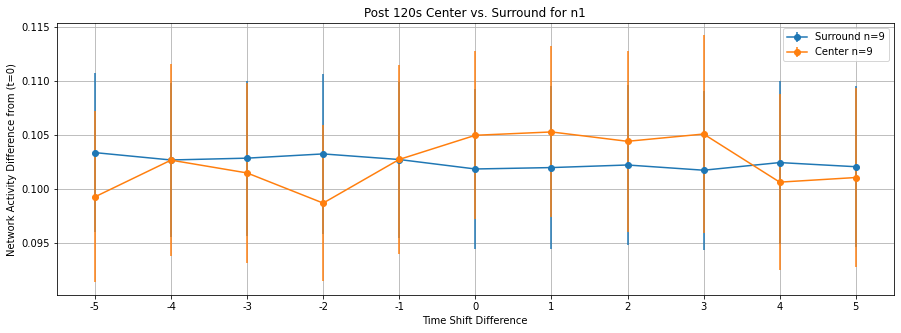

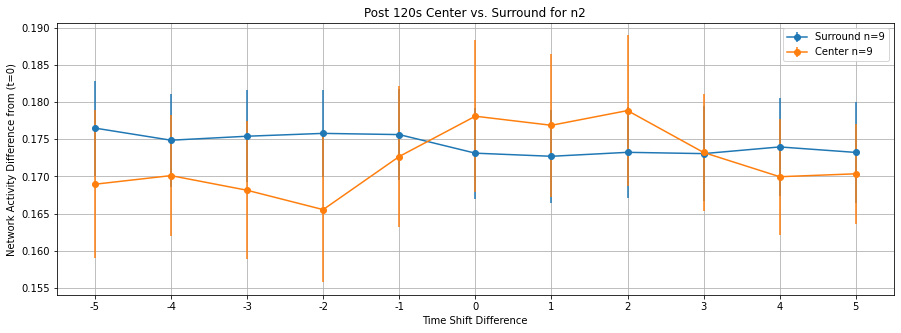

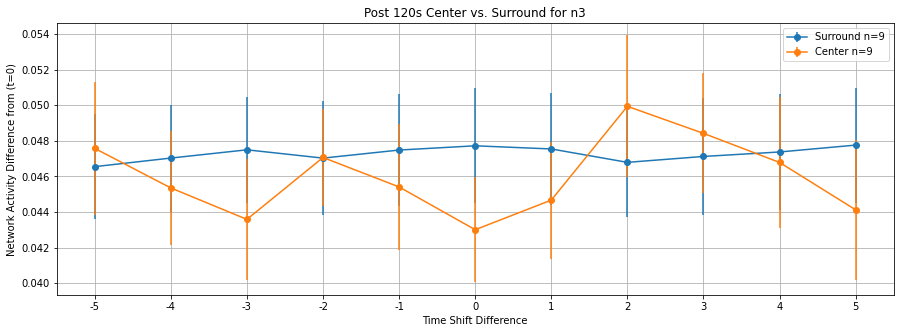

,mouse,location,network,mean_surr_score,-5,-4,-3,-2,-1,0,1,2,3,4,5
0,Mouse04203,ctr,1,0.10331,0.089232,0.113838,0.114905,0.107089,0.10058,0.104019,0.108308,0.104866,0.107306,0.092975,0.094588
1,Mouse39115,ctr,1,0.090425,0.074778,0.078039,0.079329,0.075571,0.081635,0.081399,0.080356,0.084353,0.087004,0.086447,0.087294
2,Mouse39121,ctr,1,0.143542,0.142827,0.150587,0.145877,0.132487,0.152097,0.146346,0.149124,0.155601,0.1567,0.14435,0.149059
3,Mouse39122,ctr,1,0.07256,0.081757,0.072136,0.07295,0.075663,0.076111,0.090424,0.088666,0.079799,0.070853,0.071643,0.072676
4,Mouse39132,ctr,1,0.12873,0.133054,0.137558,0.13686,0.132438,0.140564,0.140507,0.139723,0.1389,0.143641,0.136834,0.137061
5,Mouse39135,ctr,1,0.075945,0.071027,0.072381,0.074614,0.076068,0.074001,0.075027,0.07708,0.081116,0.079575,0.073155,0.073243
6,Mouse69061,ctr,1,0.087002,0.089678,0.087504,0.086728,0.085528,0.086166,0.089676,0.089512,0.085393,0.08611,0.086045,0.087795
7,Mouse69071,ctr,1,0.115061,0.112242,0.112459,0.105907,0.109743,0.110859,0.109854,0.111261,0.107963,0.114816,0.112792,0.106593
8,Mouse69075,ctr,1,0.099727,0.098783,0.099547,0.096197,0.093609,0.102625,0.107559,0.10356,0.10178,0.09985,0.101442,0.101226
9,Mouse04203,surr,1,0.10331,0.106047,0.103364,0.10338,0.10394,0.104155,0.10331,0.102968,0.103327,0.103368,0.104565,0.104065


In [151]:
offset = 150

sliding_avg_size=5

allMice_ctr_means = []
allMice_surr_means = []

allDiffs_ctr = []
allDiffs_surr = []

ctr_time_means = []
surr_time_means = []

mouse_n1_mean_surr_score = []
mouse_n2_mean_surr_score = []
mouse_n3_mean_surr_score = []

for mouse in np.unique(df_in_task.mouse):
    
    print(mouse)
    mouse_mask = df_in_task.mouse==mouse
    nan_filter = 1 - np.isnan(df_in_task.roi) 
    mask = np.logical_and(mouse_mask,nan_filter)
    startTime = np.min(df_in_task[mask==1]["time"])
    
    time_mask = np.logical_and(df_in_task["time"] < startTime + 300,
                               df_in_task["time"] >= startTime+offset)
    
    mask = np.logical_and(mask,time_mask)
    
    in_center = df_in_task[mask==1].roi.values
    
    mouse_time = df_in_task[mask==1]["time"].values
    mouse_roi = df_in_task[mask==1]["roi"].values
    
    surround_mask = np.logical_and(mask,
                                   df_in_task["roi"]==0)
    
    surround_time = np.logical_and(df_in_task["time"] < startTime + 300 - 5,
                               df_in_task["time"] >= startTime+offset + 5)
    
    surround_mask = np.logical_and(surround_mask,surround_time)
    
    #nagg_s = df_in_task[mask==1]["agg score"].values
    n1_s = df_in_task[mask==1]["net 1 scores"].values #/ np.mean(df_in_task[surround_mask==1]["net 1 scores"].values)
    n2_s = df_in_task[mask==1]["net 2 scores"].values #/ np.mean(df_in_task[surround_mask==1]["net 2 scores"].values)
    n3_s = df_in_task[mask==1]["net 3 scores"].values #/ np.mean(df_in_task[surround_mask==1]["net 3 scores"].values)
    
    mouse_n1_mean_surr_score.append(np.mean(df_in_task[surround_mask==1]["net 1 scores"].values))
    mouse_n2_mean_surr_score.append(np.mean(df_in_task[surround_mask==1]["net 2 scores"].values))
    mouse_n3_mean_surr_score.append(np.mean(df_in_task[surround_mask==1]["net 3 scores"].values))

    mouse_ctr_avgs = []
    mouse_surr_avgs = []
    mouse_avgs = []
    all_times = []
    ctr_centers = []
    surr_centers = []
    postFirstEntry=False
    
    for idx, roi in enumerate(mouse_roi):
        
        if idx >= sliding_avg_size and idx < (len(mouse_roi) - sliding_avg_size):
            
            #nagg_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n1_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n2_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n3_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            
            center_time = mouse_time[idx]
            start_time = center_time - sliding_avg_size
            end_time = center_time + sliding_avg_size
            cont_time = np.arange(start_time,end_time+1)
            
            actual_time = mouse_time[idx-sliding_avg_size:idx+sliding_avg_size+1]
            
            #actual_nagg_scores = nagg_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n1_scores = n1_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n2_scores = n2_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n3_scores = n3_s[idx-sliding_avg_size:idx+sliding_avg_size+1]

            for i,time in enumerate(cont_time):
                if time in actual_time:
                    temp_mask = actual_time==time
                    #nagg_slice[i] = actual_nagg_scores[temp_mask==1][0]
                    n1_slice[i] = actual_n1_scores[temp_mask==1][0]
                    n2_slice[i] = actual_n2_scores[temp_mask==1][0]
                    n3_slice[i] = actual_n3_scores[temp_mask==1][0]
                    
            slice_means = [#nagg_slice,
                           n1_slice,
                           n2_slice,
                           n3_slice]
            
            all_times.append(center_time)
            mouse_avgs.append(np.array(slice_means))
            #if in the open arms
            if roi==1 and (center_time - startTime) >= offset and (center_time - startTime)<300: 
                #postFirstEntry=True
                #print(mouse,center_time-startTime)
                mouse_ctr_avgs.append(slice_means)
                ctr_centers.append(center_time)
                
            elif roi==0 and (center_time - startTime) >= offset and (center_time - startTime)<300:
                mouse_surr_avgs.append(slice_means)
                surr_centers.append(center_time)
                
            
    ctr_time_means.append(np.mean(ctr_centers) - startTime)
    surr_time_means.append(np.mean(surr_centers) - startTime)
    
    mouse_ctr_slice_mean = np.nanmean(mouse_ctr_avgs,axis=0)
    mouse_surr_slice_mean = np.nanmean(mouse_surr_avgs,axis=0)
    
    allMice_ctr_means.append(mouse_ctr_slice_mean)
    allMice_surr_means.append(mouse_surr_slice_mean)
    
    #print("First Center Entry Latency in Seconds ",np.min(ctr_centers) - np.min(mouse_time))
    #print("First Saved Surround Timepoint ",np.min(surr_centers) - np.min(mouse_time))

allMice_ctr_means = np.array(allMice_ctr_means)
allMice_surr_means = np.array(allMice_surr_means)
mean_surr_scores = np.array([mouse_n1_mean_surr_score,
                           mouse_n2_mean_surr_score,
                           mouse_n3_mean_surr_score])

df_list = []
for i, net in zip(range(4),["n1","n2","n3"]):

    plt.figure(figsize=(15,5))
    #shared_meanish = np.mean(allMice_ctr_means,axis=0)[i][5] / 2 + np.mean(allMice_surr_means,axis=0)[i][5] / 2
    #plt.subplot(1,2,1)
    ctr_mean = np.mean(allMice_ctr_means,axis=0)
    ctr_stderr = np.std(allMice_ctr_means,axis=0) / np.sqrt(len(allMice_ctr_means))
    
    surr_mean = np.mean(allMice_surr_means,axis=0)
    surr_stderr = np.std(allMice_surr_means,axis=0) / np.sqrt(len(allMice_surr_means))

    plt.grid()
    plt.errorbar(np.arange(11),surr_mean[i,:],yerr=surr_stderr[i,:],fmt="-o", label="Surround n={}".format(len(allMice_surr_means)))
    plt.xticks(np.arange(11), np.arange(11)-5)
    
    plt.errorbar(np.arange(11),ctr_mean[i,:],yerr=ctr_stderr[i,:],fmt="-o", label="Center n={}".format(len(allMice_ctr_means)))
    plt.xticks(np.arange(11), np.arange(11)-5)


    #plt.title("Center for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    #plt.subplot(1,2,2)

    plt.title("Post 120s Center vs. Surround for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    plt.legend()
    plt.show()
    
    ctr_surr_mat = np.vstack([allMice_ctr_means[:,i,:],
                              allMice_surr_means[:,i,:]])
    mice = np.vstack([np.unique(df_in_task.mouse).reshape(-1,1),
                      np.unique(df_in_task.mouse).reshape(-1,1)])
    
    mean_net_surr_scores = np.vstack([mean_surr_scores[i,:].reshape(-1,1),
                                      mean_surr_scores[i,:].reshape(-1,1)])
    
    ctr_vs_surr = np.hstack([["ctr" for _ in range(9)],
                             ["surr" for _ in range(9)]]).reshape(-1,1)
    
    net_number = np.hstack([[i+1 for _ in range(9)],
                             [i+1 for _ in range(9)]]).reshape(-1,1)
    
    saveData = np.hstack([mice,ctr_vs_surr,net_number,mean_net_surr_scores,ctr_surr_mat]).astype(object)
    
    df_saveData = pd.DataFrame(saveData,
                               columns = ["mouse","location","network","mean_surr_score"] + list(np.arange(-5,6).astype(str)))
    
    df_list.append(df_saveData)
    
df_complete = pd.concat(df_list)
df_complete.to_csv(PROJECT_PATH + "150s_filterd_BOF_11s_slice_data.csv")
df_complete

In [143]:
mouse_n1_mean_surr_score

[0.10330962775384614]

In [146]:
np.mean(allMice_surr_means,axis=0)[0,6]

0.10297135568217049

In [70]:
np.mean(df_in_task[surround_mask==1]["net 1 scores"].values)

0.0993729405819672

In [79]:
np.array(ctr_centers) - startTime

array([160, 161, 162, 163, 164, 170, 171, 183, 184, 199, 200, 212, 226,
       227, 228, 229, 230, 246, 247, 253, 254, 257, 261, 264, 265, 287,
       288, 289])

In [42]:
np.max(mouse_time)

708

In [43]:
np.max(df_in_task[df_in_task.mouse==mouse]["time"])

729

In [102]:
np.mean(allMice_surr_means[:,0,6])

0.9965101928895154

Mouse04203
Mouse39115
Mouse39121
Mouse39122
Mouse39132
Mouse39135
Mouse69061
Mouse69071
Mouse69075


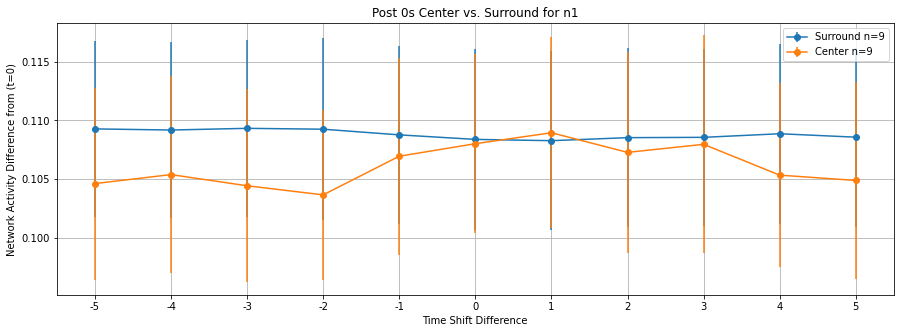

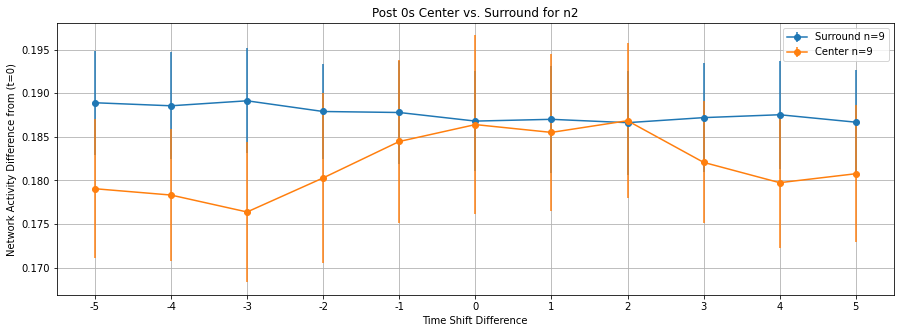

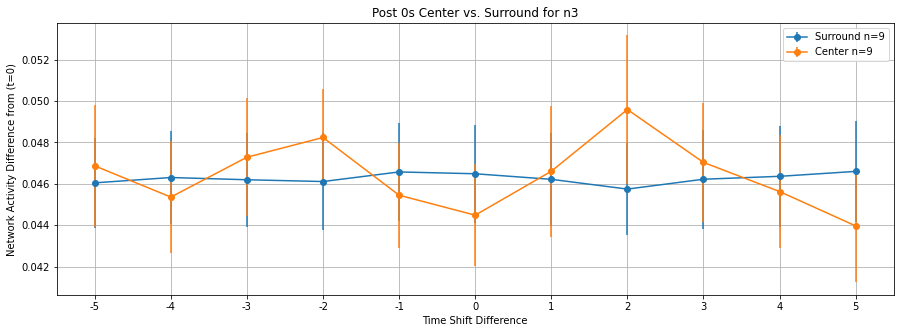

,mouse,location,network,mean_surr_score,-5,-4,-3,-2,-1,0,1,2,3,4,5
0,Mouse04203,ctr,1,0.108291,0.10328,0.110091,0.109759,0.107928,0.112331,0.109384,0.112524,0.111387,0.114706,0.107641,0.10442
1,Mouse39115,ctr,1,0.097077,0.081099,0.082426,0.082941,0.081661,0.084475,0.084839,0.084138,0.084208,0.08525,0.08672,0.083929
2,Mouse39121,ctr,1,0.155167,0.155575,0.155525,0.154233,0.140508,0.153503,0.150055,0.156942,0.16141,0.163302,0.152366,0.158478
3,Mouse39122,ctr,1,0.078869,0.080908,0.078536,0.074872,0.080991,0.081996,0.092182,0.090488,0.082016,0.074426,0.078619,0.080376
4,Mouse39132,ctr,1,0.13013,0.129013,0.134043,0.13281,0.13656,0.14378,0.14254,0.141625,0.137193,0.139173,0.131358,0.135192
5,Mouse39135,ctr,1,0.080175,0.075337,0.076568,0.080448,0.08278,0.079911,0.080291,0.080145,0.081841,0.07932,0.07904,0.078254
6,Mouse69061,ctr,1,0.09725,0.094961,0.092999,0.089963,0.089347,0.091946,0.095757,0.096273,0.090602,0.092782,0.092693,0.093264
7,Mouse69071,ctr,1,0.122398,0.116204,0.112497,0.110341,0.113373,0.11222,0.110738,0.112513,0.110274,0.120043,0.116181,0.107351
8,Mouse69075,ctr,1,0.105912,0.105284,0.105852,0.104636,0.099884,0.102424,0.106386,0.105905,0.106604,0.102689,0.103507,0.102794
9,Mouse04203,surr,1,0.108291,0.109116,0.108504,0.108277,0.108612,0.107966,0.108291,0.107925,0.108278,0.107917,0.108662,0.108977


In [152]:
offset = 0

sliding_avg_size=5

allMice_ctr_means = []
allMice_surr_means = []

allDiffs_ctr = []
allDiffs_surr = []

ctr_time_means = []
surr_time_means = []

mouse_n1_mean_surr_score = []
mouse_n2_mean_surr_score = []
mouse_n3_mean_surr_score = []

for mouse in np.unique(df_in_task.mouse):
    
    print(mouse)
    mouse_mask = df_in_task.mouse==mouse
    nan_filter = 1 - np.isnan(df_in_task.roi) 
    mask = np.logical_and(mouse_mask,nan_filter)
    startTime = np.min(df_in_task[mask==1]["time"])
    
    time_mask = np.logical_and(df_in_task["time"] < startTime + 300,
                               df_in_task["time"] >= startTime+offset)
    
    mask = np.logical_and(mask,time_mask)
    
    in_center = df_in_task[mask==1].roi.values
    
    mouse_time = df_in_task[mask==1]["time"].values
    mouse_roi = df_in_task[mask==1]["roi"].values
    
    surround_mask = np.logical_and(mask,
                                   df_in_task["roi"]==0)
    
    surround_time = np.logical_and(df_in_task["time"] < startTime + 300 - 5,
                               df_in_task["time"] >= startTime+offset + 5)
    
    surround_mask = np.logical_and(surround_mask,surround_time)
    
    #nagg_s = df_in_task[mask==1]["agg score"].values
    n1_s = df_in_task[mask==1]["net 1 scores"].values #/ np.mean(df_in_task[surround_mask==1]["net 1 scores"].values)
    n2_s = df_in_task[mask==1]["net 2 scores"].values #/ np.mean(df_in_task[surround_mask==1]["net 2 scores"].values)
    n3_s = df_in_task[mask==1]["net 3 scores"].values #/ np.mean(df_in_task[surround_mask==1]["net 3 scores"].values)
    
    mouse_n1_mean_surr_score.append(np.mean(df_in_task[surround_mask==1]["net 1 scores"].values))
    mouse_n2_mean_surr_score.append(np.mean(df_in_task[surround_mask==1]["net 2 scores"].values))
    mouse_n3_mean_surr_score.append(np.mean(df_in_task[surround_mask==1]["net 3 scores"].values))

    mouse_ctr_avgs = []
    mouse_surr_avgs = []
    mouse_avgs = []
    all_times = []
    ctr_centers = []
    surr_centers = []
    postFirstEntry=False
    
    for idx, roi in enumerate(mouse_roi):
        
        if idx >= sliding_avg_size and idx < (len(mouse_roi) - sliding_avg_size):
            
            #nagg_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n1_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n2_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n3_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            
            center_time = mouse_time[idx]
            start_time = center_time - sliding_avg_size
            end_time = center_time + sliding_avg_size
            cont_time = np.arange(start_time,end_time+1)
            
            actual_time = mouse_time[idx-sliding_avg_size:idx+sliding_avg_size+1]
            
            #actual_nagg_scores = nagg_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n1_scores = n1_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n2_scores = n2_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n3_scores = n3_s[idx-sliding_avg_size:idx+sliding_avg_size+1]

            for i,time in enumerate(cont_time):
                if time in actual_time:
                    temp_mask = actual_time==time
                    #nagg_slice[i] = actual_nagg_scores[temp_mask==1][0]
                    n1_slice[i] = actual_n1_scores[temp_mask==1][0]
                    n2_slice[i] = actual_n2_scores[temp_mask==1][0]
                    n3_slice[i] = actual_n3_scores[temp_mask==1][0]
                    
            slice_means = [#nagg_slice,
                           n1_slice,
                           n2_slice,
                           n3_slice]
            
            all_times.append(center_time)
            mouse_avgs.append(np.array(slice_means))
            #if in the open arms
            if roi==1 and (center_time - startTime) >= offset and (center_time - startTime)<300: 
                #postFirstEntry=True
                #print(mouse,center_time-startTime)
                mouse_ctr_avgs.append(slice_means)
                ctr_centers.append(center_time)
                
            elif roi==0 and (center_time - startTime) >= offset and (center_time - startTime)<300:
                mouse_surr_avgs.append(slice_means)
                surr_centers.append(center_time)
                
            
    ctr_time_means.append(np.mean(ctr_centers) - startTime)
    surr_time_means.append(np.mean(surr_centers) - startTime)
    
    mouse_ctr_slice_mean = np.nanmean(mouse_ctr_avgs,axis=0)
    mouse_surr_slice_mean = np.nanmean(mouse_surr_avgs,axis=0)
    
    allMice_ctr_means.append(mouse_ctr_slice_mean)
    allMice_surr_means.append(mouse_surr_slice_mean)
    
    #print("First Center Entry Latency in Seconds ",np.min(ctr_centers) - np.min(mouse_time))
    #print("First Saved Surround Timepoint ",np.min(surr_centers) - np.min(mouse_time))

allMice_ctr_means = np.array(allMice_ctr_means)
allMice_surr_means = np.array(allMice_surr_means)
mean_surr_scores = np.array([mouse_n1_mean_surr_score,
                           mouse_n2_mean_surr_score,
                           mouse_n3_mean_surr_score])

df_list = []
for i, net in zip(range(4),["n1","n2","n3"]):

    plt.figure(figsize=(15,5))
    #shared_meanish = np.mean(allMice_ctr_means,axis=0)[i][5] / 2 + np.mean(allMice_surr_means,axis=0)[i][5] / 2
    #plt.subplot(1,2,1)
    ctr_mean = np.mean(allMice_ctr_means,axis=0)
    ctr_stderr = np.std(allMice_ctr_means,axis=0) / np.sqrt(len(allMice_ctr_means))
    
    surr_mean = np.mean(allMice_surr_means,axis=0)
    surr_stderr = np.std(allMice_surr_means,axis=0) / np.sqrt(len(allMice_surr_means))

    plt.grid()
    plt.errorbar(np.arange(11),surr_mean[i,:],yerr=surr_stderr[i,:],fmt="-o", label="Surround n={}".format(len(allMice_surr_means)))
    plt.xticks(np.arange(11), np.arange(11)-5)
    
    plt.errorbar(np.arange(11),ctr_mean[i,:],yerr=ctr_stderr[i,:],fmt="-o", label="Center n={}".format(len(allMice_ctr_means)))
    plt.xticks(np.arange(11), np.arange(11)-5)


    #plt.title("Center for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    #plt.subplot(1,2,2)

    plt.title("Post 0s Center vs. Surround for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    plt.legend()
    plt.show()
    
    ctr_surr_mat = np.vstack([allMice_ctr_means[:,i,:],
                              allMice_surr_means[:,i,:]])
    mice = np.vstack([np.unique(df_in_task.mouse).reshape(-1,1),
                      np.unique(df_in_task.mouse).reshape(-1,1)])
    
    mean_net_surr_scores = np.vstack([mean_surr_scores[i,:].reshape(-1,1),
                                      mean_surr_scores[i,:].reshape(-1,1)])
    
    ctr_vs_surr = np.hstack([["ctr" for _ in range(9)],
                             ["surr" for _ in range(9)]]).reshape(-1,1)
    
    net_number = np.hstack([[i+1 for _ in range(9)],
                             [i+1 for _ in range(9)]]).reshape(-1,1)
    
    saveData = np.hstack([mice,ctr_vs_surr,net_number,mean_net_surr_scores,ctr_surr_mat]).astype(object)
    
    df_saveData = pd.DataFrame(saveData,
                               columns = ["mouse","location","network","mean_surr_score"] + list(np.arange(-5,6).astype(str)))
    
    df_list.append(df_saveData)
    
df_complete = pd.concat(df_list)
df_complete.to_csv(PROJECT_PATH + "0s_filterd_BOF_11s_slice_data.csv")
df_complete